# Import Packages

In [467]:
"""
Main File for QRT - Electricity Price - 2023 Project
"""
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, RepeatedKFold, train_test_split, cross_val_predict
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

from scipy.stats import spearmanr

from xgboost import XGBRegressor
from xgboost import plot_importance

import warnings
warnings.filterwarnings('ignore')

# Plotting and Metric Score

In [468]:
def plot_ts(ts_x: pd.Series, ts_y: pd.Series, title: str = None, figsize=(13, 5)) -> None:
    """plots a given timeseries and displays an optional title"""
    plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    plt.plot(ts_x, ts_y)
    plt.title(title or '', fontsize=10)
    plt.grid(alpha=0.5, linestyle='dashed')
    plt.show()


def metric_train(output, Y_clean):
    return 100 * (spearmanr(output, Y_clean).correlation)

def plot_ts_y(ts_x, ts_y, title: str = None, figsize=(13, 5)) -> None:
    """plots a given timeseries and displays an optional title"""
    plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    plt.plot(ts_x, label=ts_x)
    plt.plot(ts_y, label=ts_y)
    plt.title(title or '', fontsize=10)
    plt.grid(alpha=0.5, linestyle='dashed')
    plt.show()

# Data Preprocessing

In [469]:
# Importing Data From Files
curr_dir = '/Users/talhajamal/Desktop/Code/Python_Projects/QRT - 2023 - Electricity Price/'
os.chdir(curr_dir)

X = pd.read_csv(f"{curr_dir}data/X_train_NHkHMNU.csv")#.set_index('ID').sort_values(by='DAY_ID')
y = pd.read_csv(f"{curr_dir}data/y_train_ZAN5mwg.csv")#.set_index('ID')
x_validation = pd.read_csv(f"{curr_dir}data/X_test_final.csv")#.set_index('ID')

In [470]:
X.head()

,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
0,1054,206,FR,0.210099,-0.427458,-0.606523,0.606523,NaN,0.692860,NaN,...,-0.444661,-0.172680,-0.556356,-0.790823,-0.283160,-1.069070,-0.063404,0.339041,0.124552,-0.002445
1,2049,501,FR,-0.022399,-1.003452,-0.022063,0.022063,-0.573520,-1.130838,0.573520,...,-1.183194,-1.240300,-0.770457,1.522331,0.828412,0.437419,1.831241,-0.659091,0.047114,-0.490365
2,1924,687,FR,1.395035,1.978665,1.021305,-1.021305,-0.622021,-1.682587,0.622021,...,1.947273,-0.480700,-0.313338,0.431134,0.487608,0.684884,0.114836,0.535974,0.743338,0.204952
3,297,720,DE,-0.983324,-0.849198,-0.839586,0.839586,-0.270870,0.563230,0.270870,...,-0.976974,-1.114838,-0.507570,-0.499409,-0.236249,0.350938,-0.417514,0.911652,-0.296168,1.073948
4,1101,818,FR,0.143807,-0.617038,-0.924990,0.924990,NaN,0.990324,NaN,...,-0.526267,-0.541465,-0.424550,-1.088158,-1.011560,0.614338,0.729495,0.245109,1.526606,2.614378


In [471]:
y.head()

,ID,TARGET
0,1054,0.028313
1,2049,-0.112516
2,1924,-0.180840
3,297,-0.260356
4,1101,-0.071733


In [472]:
x_validation.head()

,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
0,1115,241,FR,0.340083,-0.433604,-0.423521,0.423521,0.165333,0.519419,-0.165333,...,-0.222525,-0.513180,-0.182048,-0.982546,-0.876632,0.880491,0.692242,0.569419,-0.029697,-0.929256
1,1202,1214,FR,0.803209,0.780411,0.601610,-0.601610,0.342802,0.555367,-0.342802,...,0.857739,-0.340595,-0.301094,-0.759816,-1.221443,-0.616617,-0.737496,0.251251,0.753646,0.664086
2,1194,1047,FR,0.795540,0.721954,1.179158,-1.179158,1.620928,0.666901,-1.620928,...,0.447967,0.796475,-0.367248,0.376055,-0.483363,0.865138,0.120079,-1.485642,-0.326450,-0.349747
3,1084,1139,FR,0.172555,-0.723427,-0.044539,0.044539,NaN,-0.205276,NaN,...,-0.561295,-0.542606,-0.013291,-0.791119,-0.894309,0.239153,0.457457,-0.746863,2.262654,0.642069
4,1135,842,FR,0.949714,0.420236,0.617391,-0.617391,0.608561,-0.240856,-0.608561,...,0.503567,-0.230291,-0.609203,-0.744986,-1.196282,0.176557,0.312557,-2.219626,-0.509272,-0.488341


# Missing Data

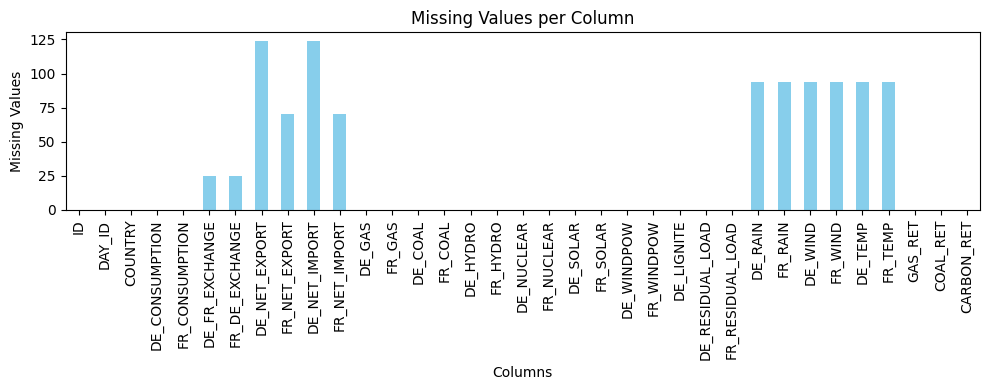

In [473]:
missing_values = X.isna().sum()
missing_values.plot(kind='bar', figsize=(10, 4), color='skyblue')
plt.title('Missing Values per Column')
plt.xlabel('Columns')
plt.ylabel('Missing Values')
plt.xticks(rotation=90)  # Rotate the x labels to show them vertically
plt.tight_layout()  # Adjust layout to make room for the x labels
plt.show()

# Fill Data

In [474]:
X.interpolate(method='polynomial',order=3, inplace=True)
X = X.fillna(0)
#X = pd.get_dummies(X, columns=['COUNTRY'])  # One Hot Encoding for each country
X = X.drop(['COUNTRY'], axis=1)

#y = pd.merge(X[['ID']], y, on='ID')  # Align the ID column of X and y
#y = X.join(y)[['TARGET']] # Align the ID column of X and y

x_validation.interpolate(method='polynomial',order=3, inplace=True)
#x_validation = x_validation.fillna(method='ffill') # Forward Fill the Missing Data
x_validation = x_validation.fillna(0)
#x_validation = pd.get_dummies(x_validation, columns=['COUNTRY']) # One Hot Encoding for each country
x_validation = x_validation.drop(['COUNTRY'], axis=1)

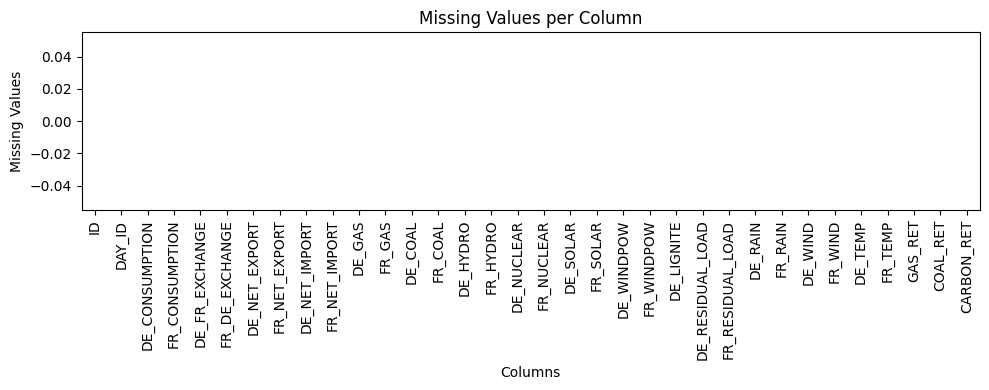

In [475]:
missing_values = X.isna().sum()
missing_values.plot(kind='bar', figsize=(10, 4), color='skyblue')
plt.title('Missing Values per Column')
plt.xlabel('Columns')
plt.ylabel('Missing Values')
plt.xticks(rotation=90)  # Rotate the x labels to show them vertically
plt.tight_layout()  # Adjust layout to make room for the x labels
plt.show()

# Feature Engineering

In [476]:
# Create Lagged Variables and Moving Averages


<Figure size 1000x500 with 0 Axes>

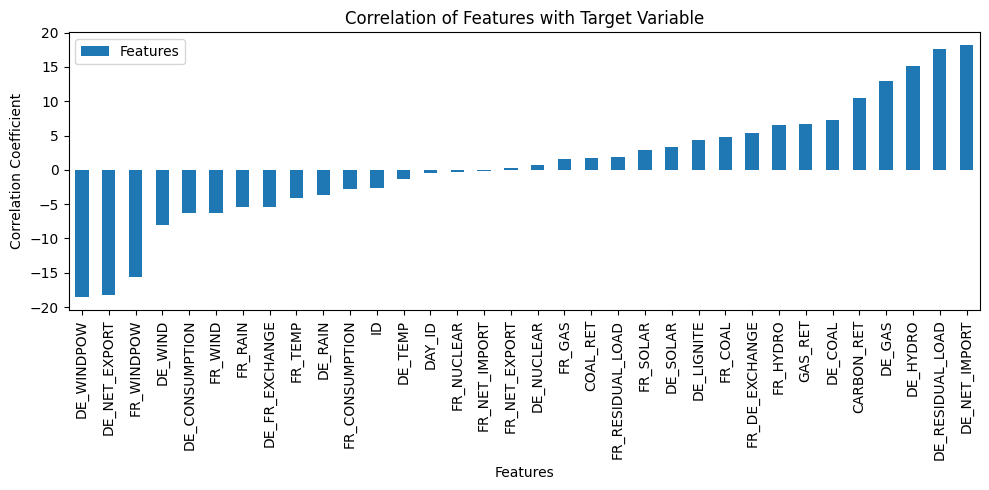

In [477]:
correlation = [metric_train(X[col], y['TARGET']) for col in X.columns]
correlation_df = pd.DataFrame(correlation, index=X.columns, columns=['Features'])
plt.figure(figsize=(10, 5))
correlation_df.sort_values(by='Features').plot(kind='bar', figsize=(10,5))
plt.title('Correlation of Features with Target Variable')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

In [478]:
low_corr = correlation_df[abs(correlation_df['Features']) < 2.5]
low_corr

,Features
DAY_ID,-0.390095
FR_NET_EXPORT,0.221174
FR_NET_IMPORT,-0.221174
FR_GAS,1.633355
DE_NUCLEAR,0.705175
FR_NUCLEAR,-0.361857
FR_RESIDUAL_LOAD,1.824129
DE_TEMP,-1.388506
COAL_RET,1.757295


In [479]:
columns_to_keep = ['COUNTRY_DE', 'COUNTRY_FR']
columns_to_drop = [column for column in low_corr.index if column not in columns_to_keep]
X_dropped = X.drop(columns=columns_to_drop)

<Figure size 1000x500 with 0 Axes>

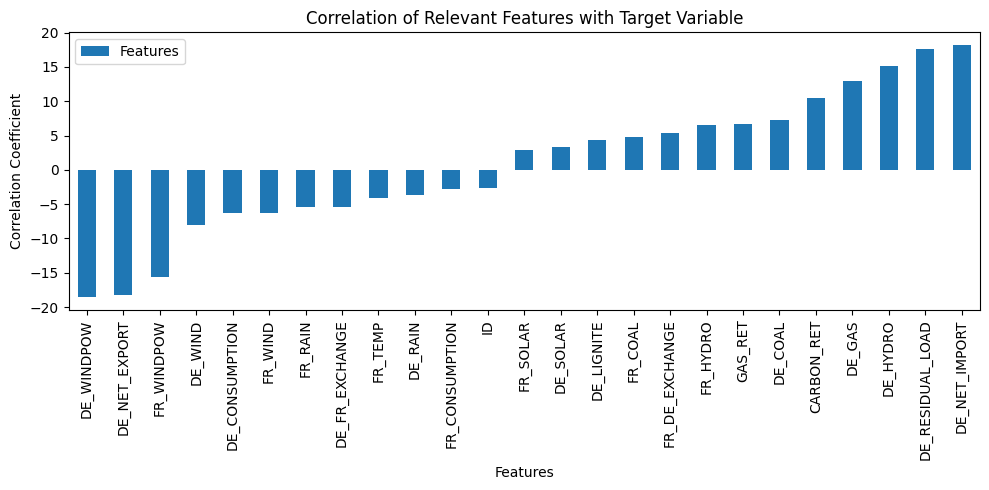

In [480]:
new_correlation = [metric_train(X_dropped[col], y['TARGET']) for col in X_dropped.columns]
new_correlation_df = pd.DataFrame(new_correlation, index=X_dropped.columns, columns=['Features'])
plt.figure(figsize=(10, 5))
new_correlation_df.sort_values(by='Features').plot(kind='bar', figsize=(10,5))
plt.title('Correlation of Relevant Features with Target Variable')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

In [481]:
new_correlation_df.sort_values(by='Features', inplace=True)
new_correlation_df

,Features
DE_WINDPOW,-18.568799
DE_NET_EXPORT,-18.200552
FR_WINDPOW,-15.556754
DE_WIND,-8.110643
DE_CONSUMPTION,-6.361683
FR_WIND,-6.329550
FR_RAIN,-5.435784
DE_FR_EXCHANGE,-5.400954
FR_TEMP,-4.105975
DE_RAIN,-3.605381


### Plot of every feature against TARGET

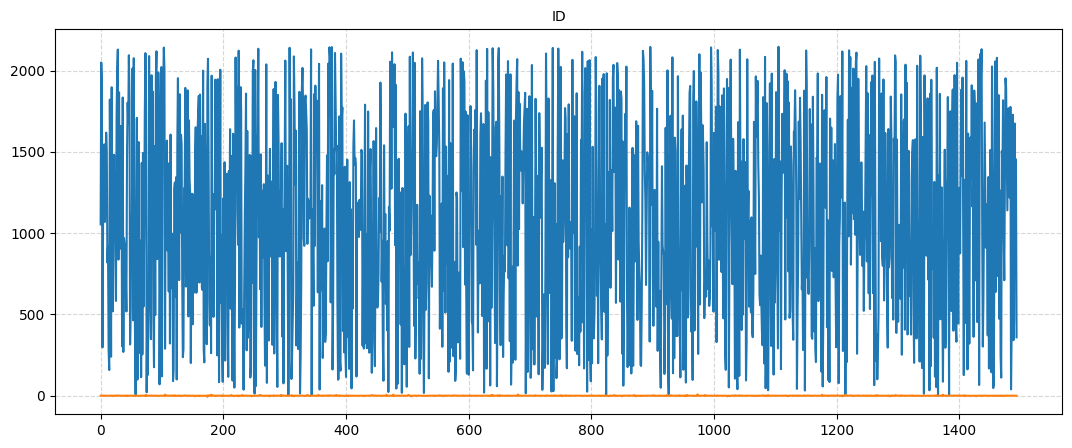

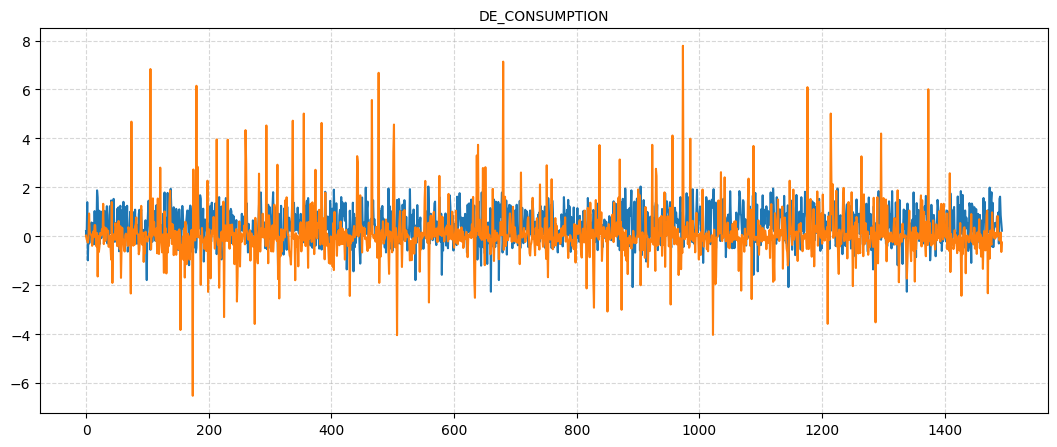

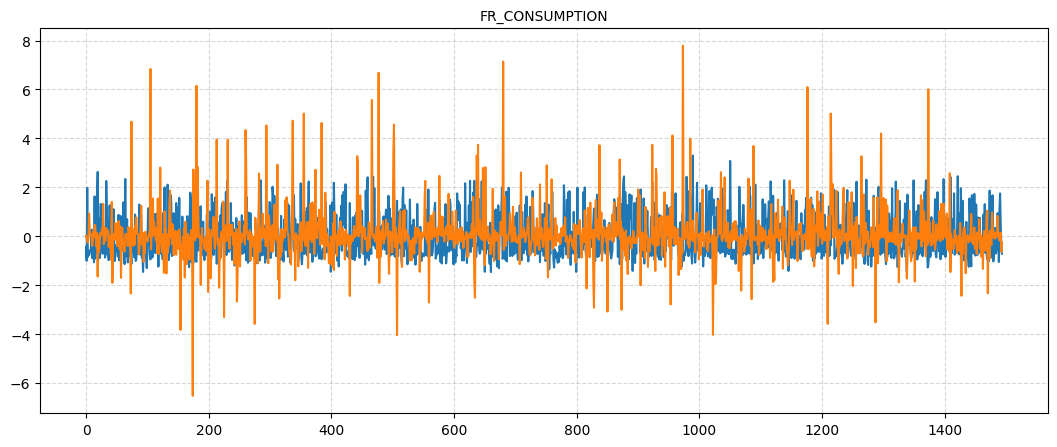

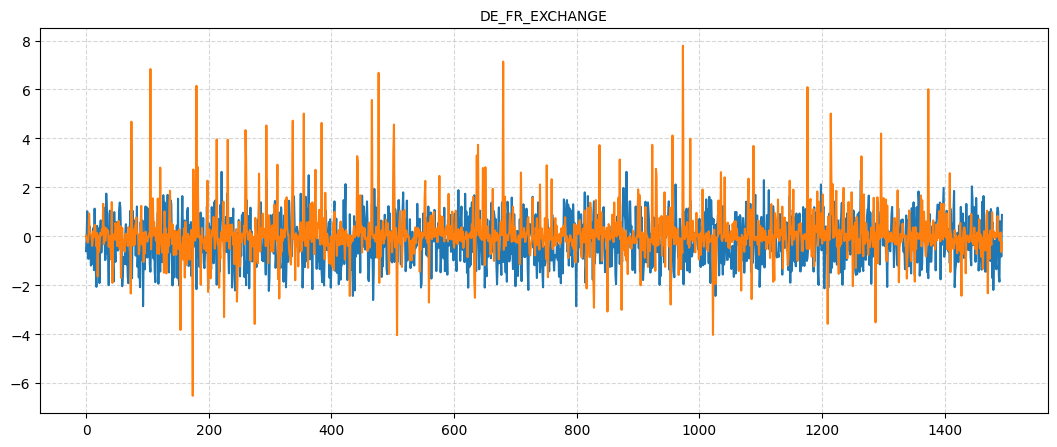

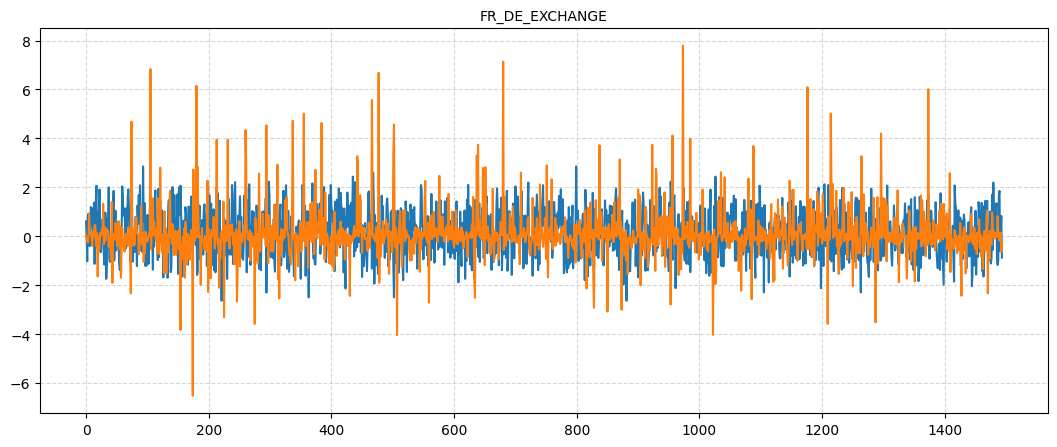

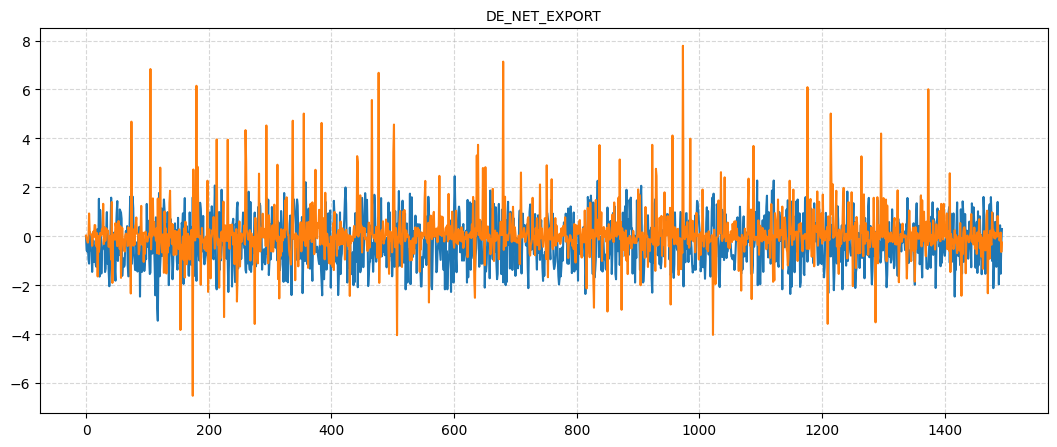

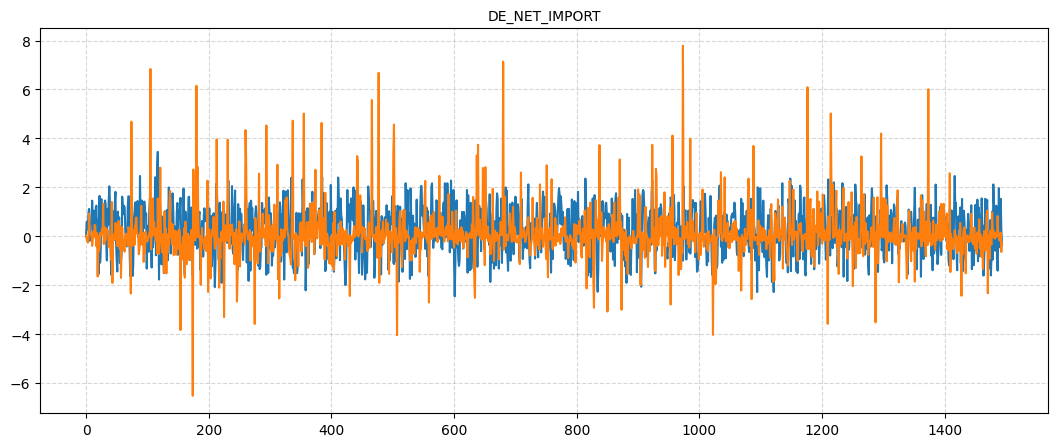

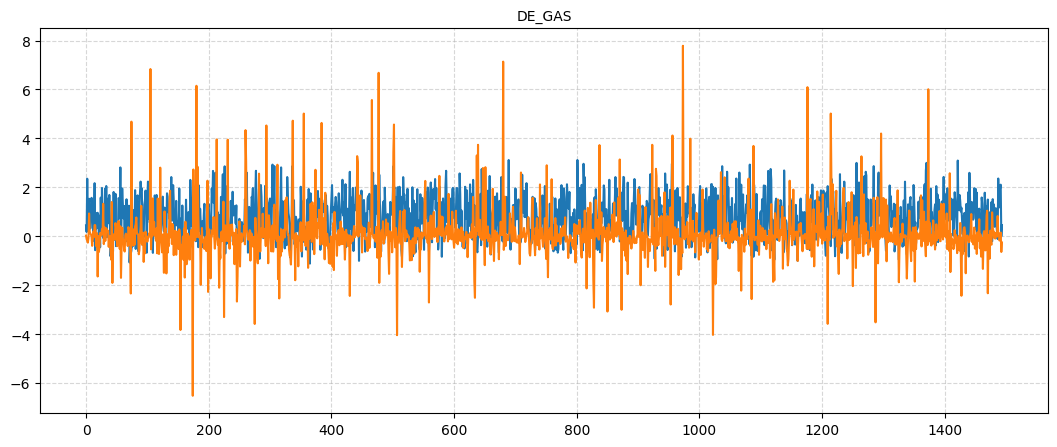

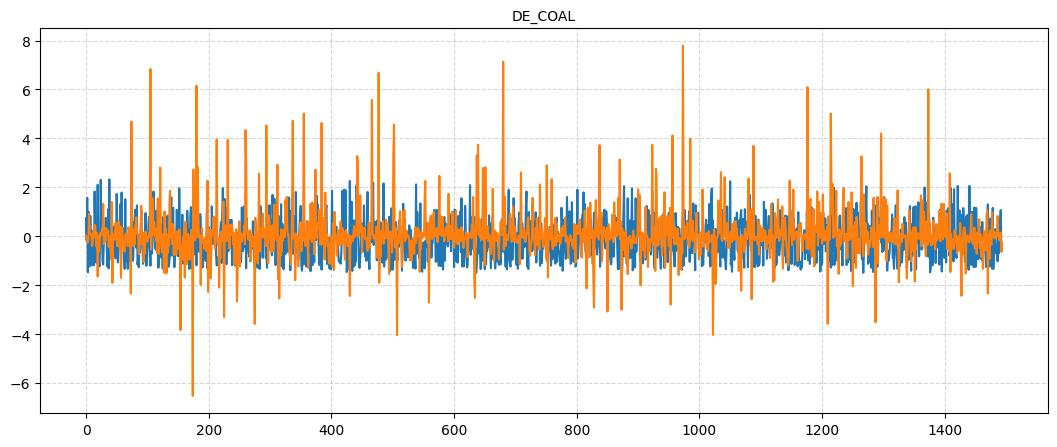

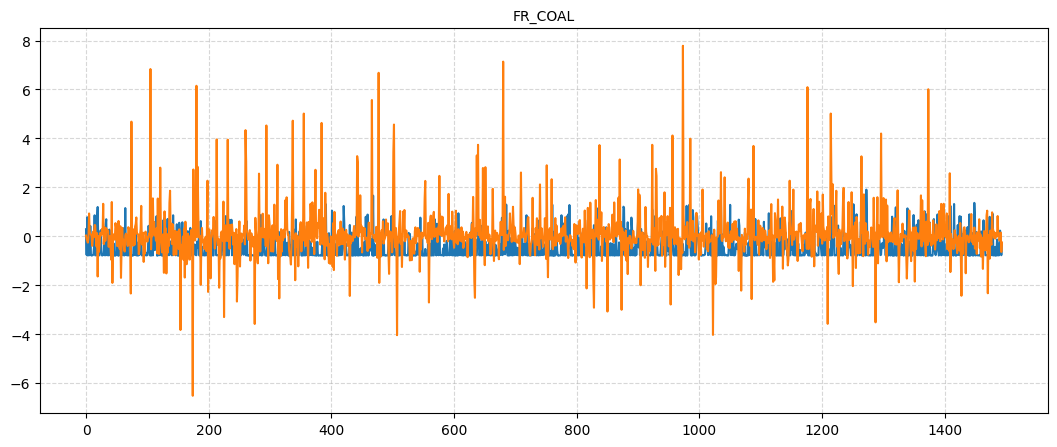

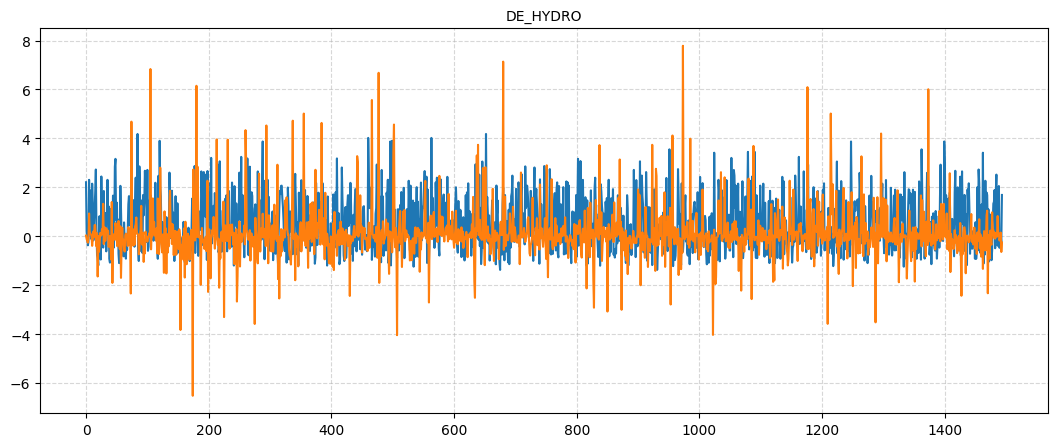

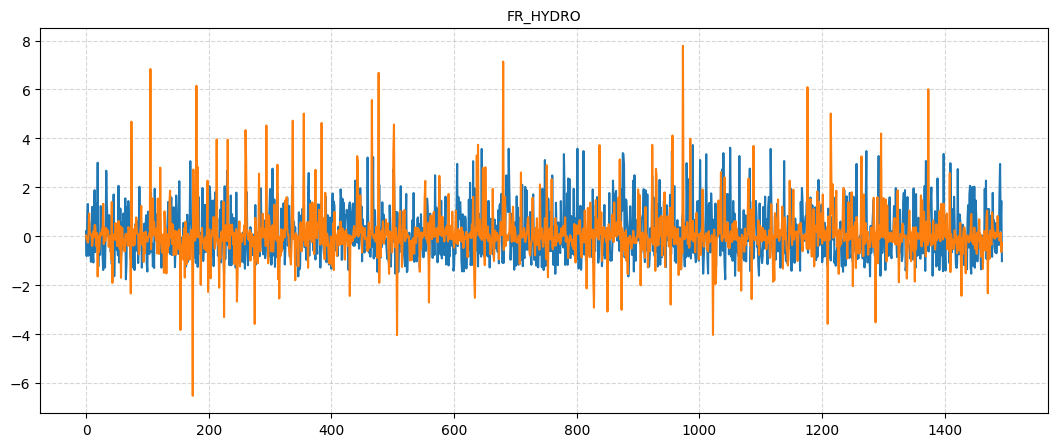

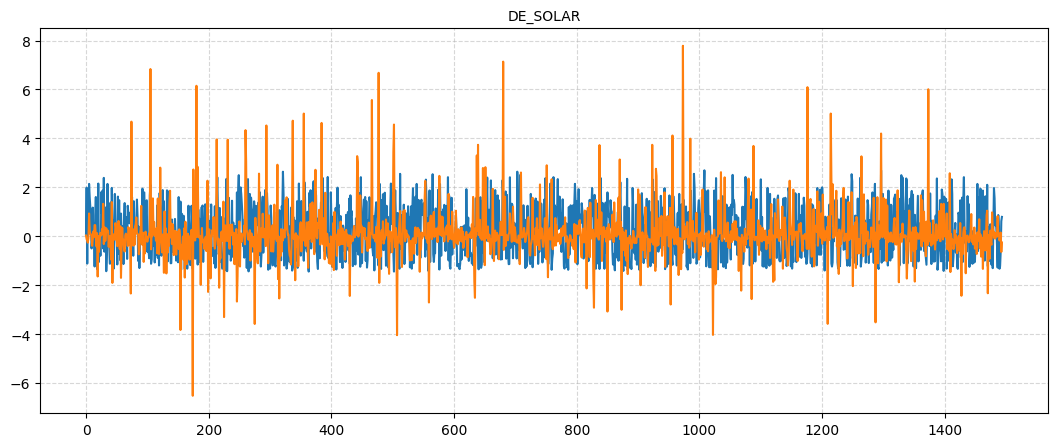

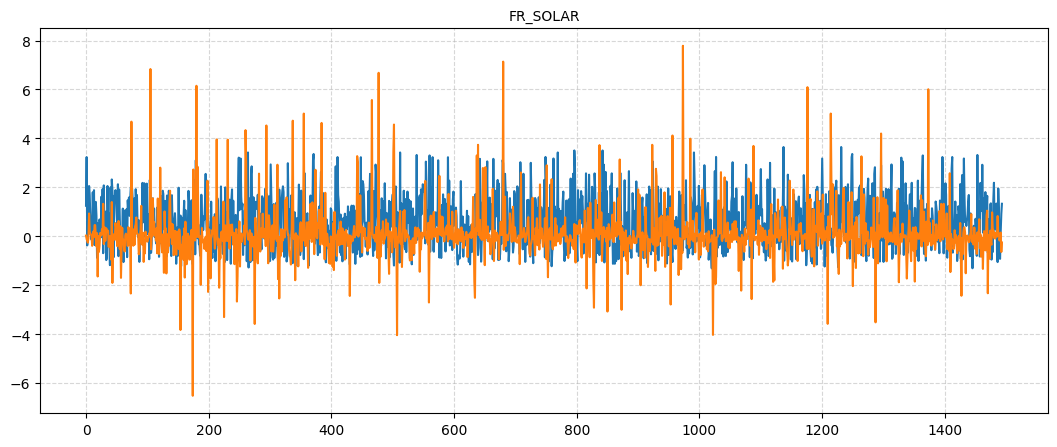

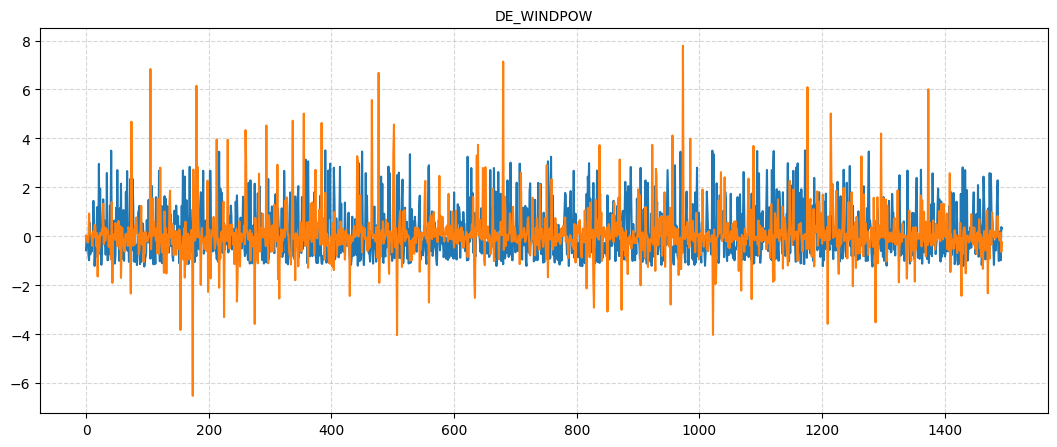

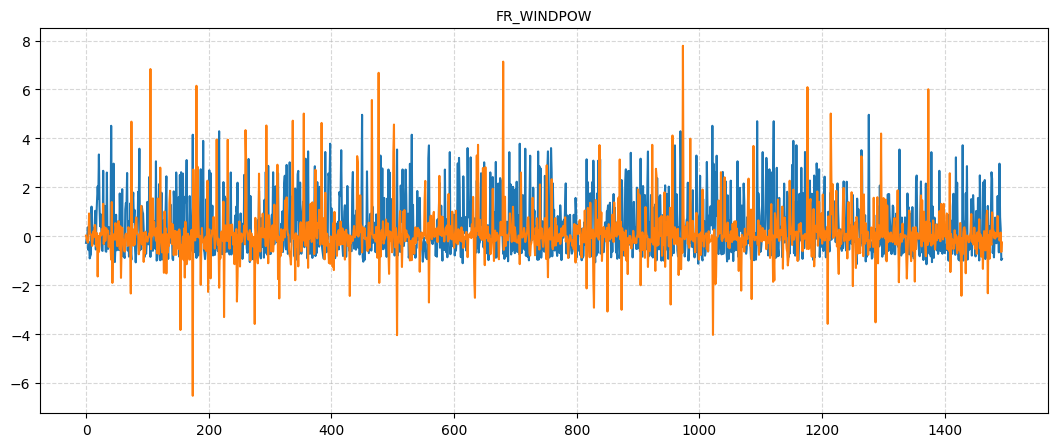

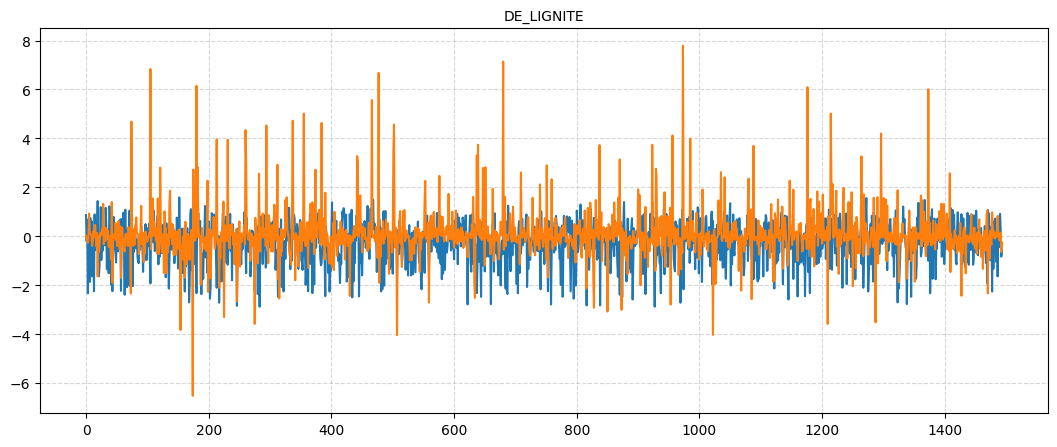

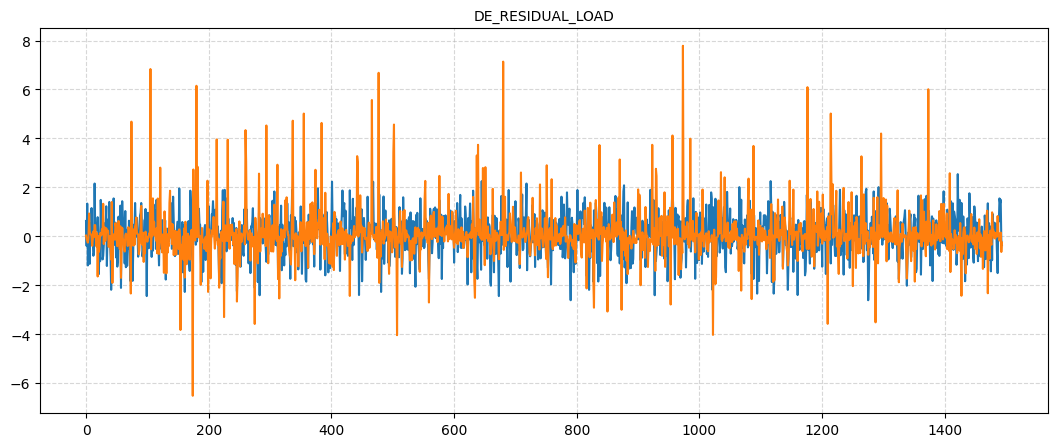

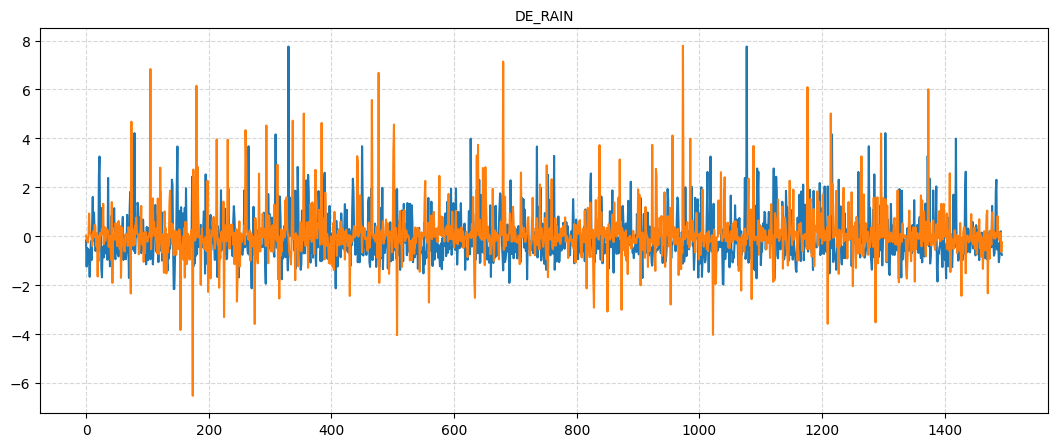

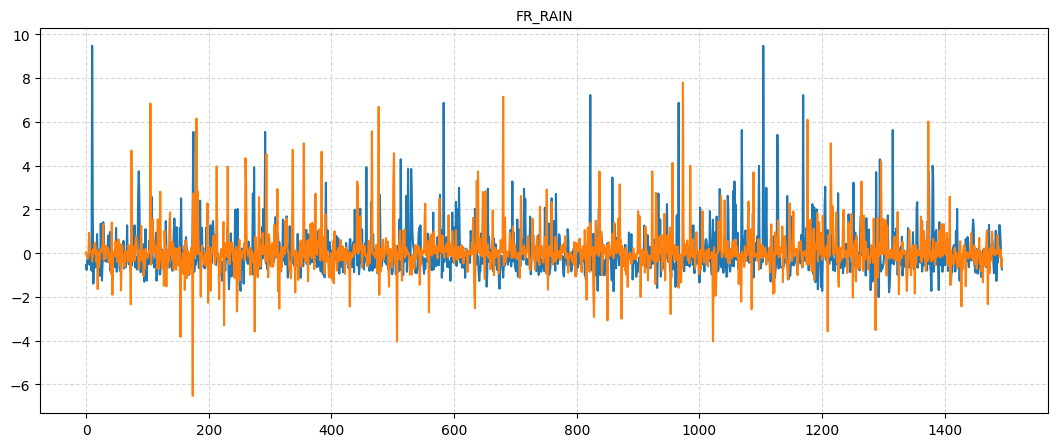

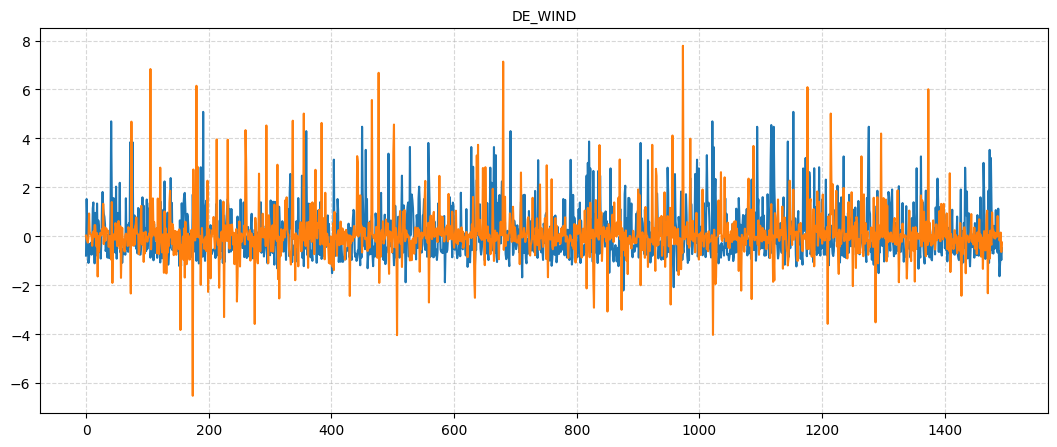

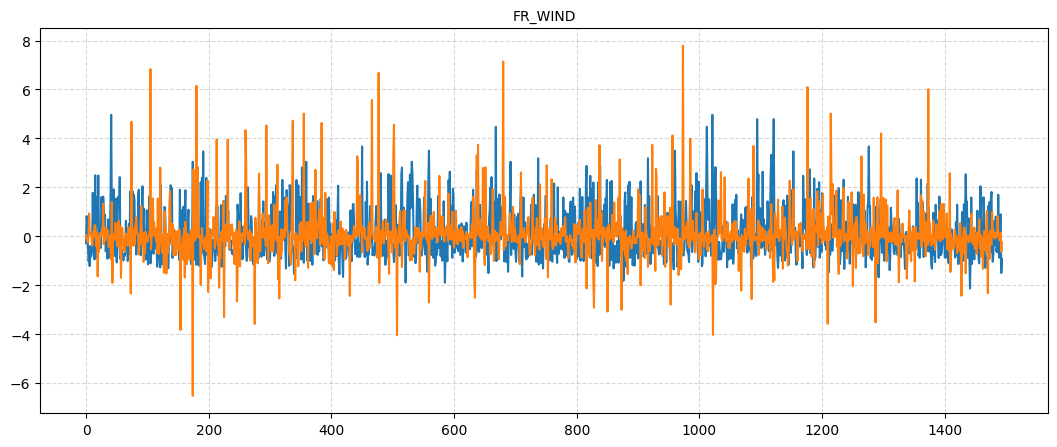

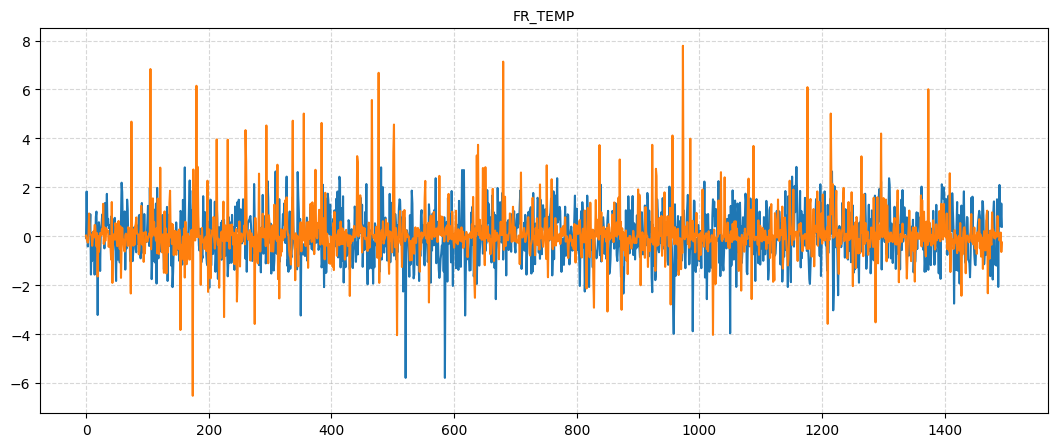

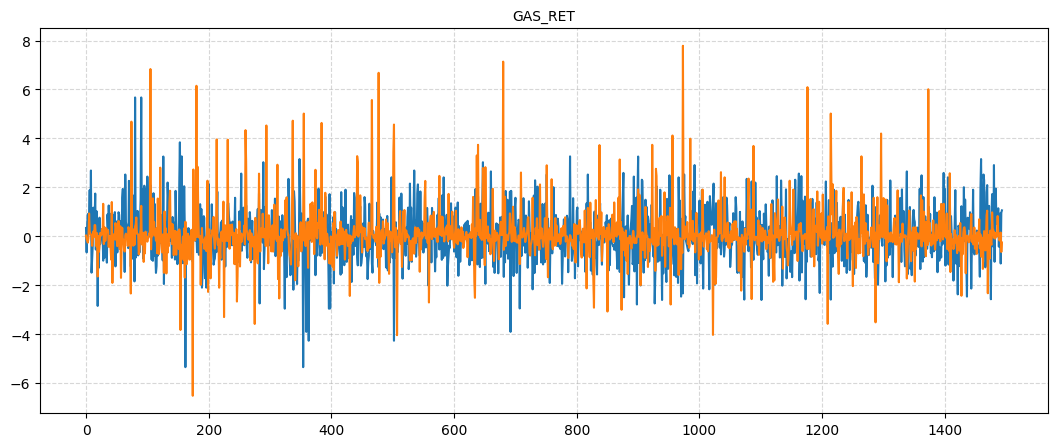

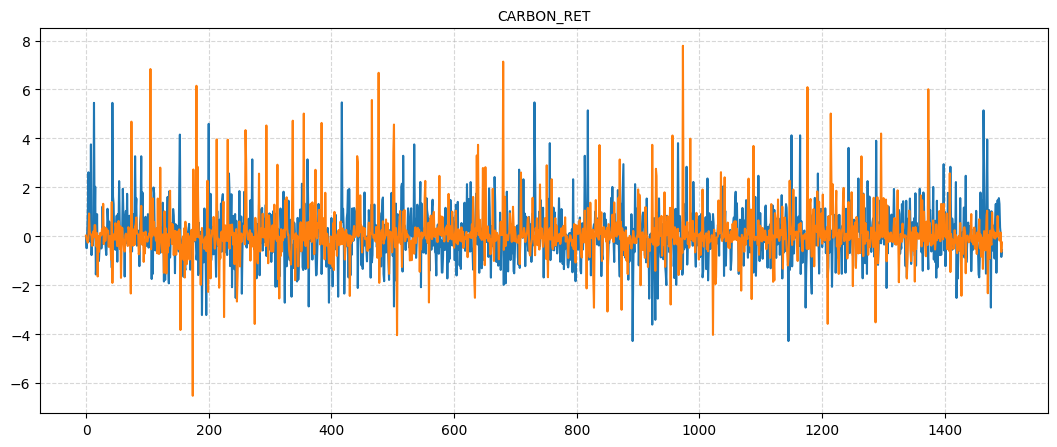

In [482]:
X_plot = X_dropped.copy(deep=True)
X_plot = X_plot.sort_index()
y_plot = y.copy(deep=True)
y_plot = y_plot.sort_index()
# Plot all data to find patterns
for col in X_plot.columns:
    if col == 'DAY_ID':
        continue
    plot_ts_y(X_plot[col], y_plot['TARGET'], title=col)

# Cross Validation for MSE using XGBRegressor

In [483]:
def XGBRegressorCrossValidationMSE(X_clean, Y_clean):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_clean, Y_clean, test_size=0.10, random_state=42)

    # Define the parameter grid
    param_grid = {
        'max_depth': [3, 6, 10],  # LightGBM's 'num_leaves' can be roughly translated to 'max_depth' in XGBoost
        'reg_alpha': [0.1, 0.2, 0.3],  # LightGBM's 'bagging_fraction' does not have a direct equivalent, but 'reg_alpha' can help with regularization
        'n_estimators': [100],  # Reduced number of options for 'n_estimators' to speed up the process
        'learning_rate': [0.05, 0.1, 0.2],  # Same as LightGBM's
        'colsample_bytree': [0.6, 0.8, 0.9],  # Similar to LightGBM's 'feature_fraction'
        'subsample': [0.6, 0.8, 0.9]  # Similar to LightGBM's 'bagging_fraction'
    }

    # Initialize the XGBRegressor
    xgb_reg = XGBRegressor(booster='gbtree', objective='reg:squarederror')
    # Create a GridSearchCV object
    grid_search = GridSearchCV(
        estimator=xgb_reg,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        return_train_score=True,
        n_jobs=-1,
        verbose=2
    )

    # Perform grid search
    grid_search.fit(X_train, y_train)

    # Results
    best_parameters = grid_search.best_params_
    best_mse = -1 * grid_search.best_score_
    best_model = grid_search.best_estimator_
    y_pred_train = cross_val_predict(best_model, X_train, y_train, cv=5)
    spearman_corr = spearmanr(y_pred_train, y_train).correlation
    y_pred_test = best_model.predict(X_test)
    mse_test = mean_squared_error(y_test, y_pred_test)

    # Output the best parameters and corresponding mean square error
    print("Best parameters found: ", grid_search.best_params_)
    print("Best MSE: ", best_mse)
    print("Spearman correlation on training data: ", spearman_corr)
    print("MSE on test data: ", mse_test)

    # Prepare the result dictionary
    result = {
        "model": best_model,
        "best_parameters": best_parameters,
        "best_mse": best_mse,
        "mse_test": mse_test,
        "spearman_correlation_train": spearman_corr
    }

    return result


# LightGBM model

In [484]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_predict

def LGBRegressorCrossValidationMSE(X_clean, Y_clean):

    X_train, X_test, y_train, y_test = train_test_split(X_clean, Y_clean, test_size=0.10, random_state=42)

    # define parameter space
    param_grid = {
        'num_leaves': [15, 31, 50],
        'learning_rate': [0.05, 0.1, 0.2],
        'feature_fraction': [0.6, 0.8, 0.9],
        'bagging_fraction': [0.6, 0.8, 0.9],
        'bagging_freq': [3, 5, 7]
    }

    # build the LightGBM model
    lgbm = LGBMRegressor(boosting_type='gbdt', objective='regression', metric='mse')
    # build the GridSearchCV on LightGBM
    grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
    # grid search
    grid_search.fit(X_train, y_train)
    
    # results
    best_parameters = grid_search.best_params_
    best_mse = -1 * grid_search.best_score_
    best_model = grid_search.best_estimator_
    y_pred_train = cross_val_predict(best_model, X_train, y_train, cv=5)
    spearman_corr = spearmanr(y_pred_train, y_train).correlation * 100
    # calculate the target test data
    y_pred_test = best_model.predict(X_test)
    # Calculate MSE for test data
    mse_test = mean_squared_error(y_test, y_pred_test)

    # Print Results
    print("Best parameters found: ", best_parameters)
    print("Best mse: ", best_mse)
    print("Best Spearman correlation:", spearman_corr)
    print("MSE on test data: ", mse_test)

    result = {
        "parameters": best_parameters,
        "model":best_model,
        "Best MSE": best_mse,
        "Test MSE":mse_test,
        "Metric Score": spearman_corr
    }
    return result

# XGBoost Regression

In [485]:
#X_clean = X.iloc[:, 1:] # X_clean should not have the ID column
X_clean = X_dropped
Y_clean = y['TARGET']

# Running the Light GBM Model 

In [ ]:
CV_LGBM = LGBRegressorCrossValidationMSE(X_clean=X_clean, Y_clean=Y_clean)

In [ ]:
# Running the LightGBM Model
light_gbm_submission = x_validation[['ID']].copy()
X_validation_clean = x_validation.iloc[:, 1:]
light_gbm_submission['TARGET'] = CV_LGBM['model'].predict(X_validation_clean)
light_gbm_submission.to_csv('light_gbm_test.csv', index=False)

In [ ]:
lgbm_feature_importances = CV_LGBM['model'].feature_importances_
lgbm_importances = pd.Series(lgbm_feature_importances, index=X_clean.columns)
lgbm_importances = lgbm_importances.sort_values()
lgbm_importances.plot(kind='bar', figsize=(10,5))
plt.title('Feature Importance for Light GBM Model')
plt.show()

# Running the XGBoost Regression

In [486]:
CV_XGB = XGBRegressorCrossValidationMSE(X_clean=X_clean, Y_clean=Y_clean)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=0.1, subsample=0.6; total time=   0.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=0.1, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=0.1, subsample=0.6; total time=   0.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=0.1, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=0.1, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=0.1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=100, reg_alpha=0.1, subsample=0.8; total time=   0.0s
[CV] END colsample_

Best parameters found:  {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0.1, 'subsample': 0.9}

In [488]:
# Running the XGB Model
xgb_submission = x_validation[['ID']].copy()
xgb_submission['TARGET'] = CV_LGBM['model'].predict(X_validation_clean)
xgb_submission.to_csv('xgb_submission.csv', index=False)

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


In [491]:
xgb_submission

,ID,TARGET
0,1115,0.007144
1,1202,0.058507
2,1194,0.146788
3,1084,-0.074099
4,1135,0.341327
...,...,...
649,879,-0.869406
650,673,-0.212577
651,1641,0.737685
652,712,0.266129


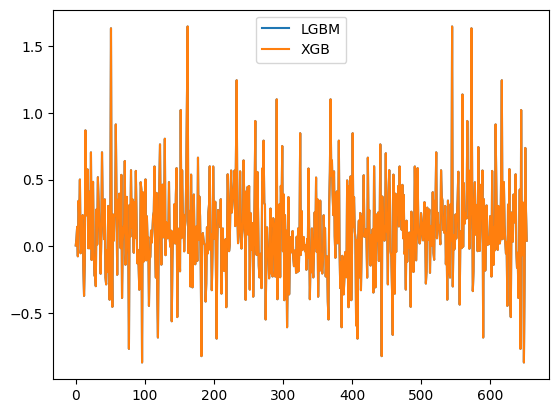

In [489]:
plt.plot(light_gbm_submission['TARGET'], label='LGBM')
plt.plot(xgb_submission['TARGET'], label='XGB')
plt.legend()

Current out of sample performance is 18.58%. This beats the benchmark Linear Regression Model's performance of 15.9%

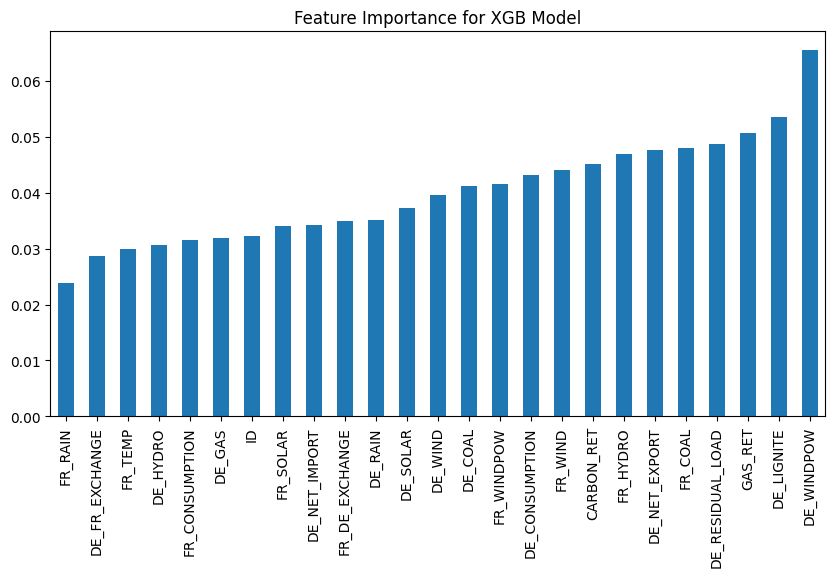

In [490]:
xgb_feature_importances = CV_XGB['model'].feature_importances_
xgb_importances = pd.Series(xgb_feature_importances, index=X_clean.columns)
xgb_importances = xgb_importances.sort_values()
xgb_importances.plot(kind='bar', figsize=(10,5))
plt.title('Feature Importance for XGB Model')
plt.show()

# Target Predictions that work better than mine

In [ ]:
# Simple Model
xgb= XGBRegressor(objective='reg:squarederror', )
xgb.fit(X_clean, Y_clean)
predictions = xgb.predict(X_clean)
y = y.sort_index()
predictions_df = pd.DataFrame(predictions, index=y.index)
print(metric_train(predictions, Y_clean))

plt.figure(figsize=(10,4))
plt.plot(y['TARGET'], label='y_true')
plt.plot(predictions_df, label='predictions')
plt.legend()
plt.title("Comparing True Training Values with No Cross Validated XGB Model")
print("Model parameters:", xgb.get_params())

In [ ]:
# Comparing Training Preditions with CV XGB Model
lgbm_predictions = lgbm_model.predict(Y_clean)
lgbm_predictions_df = pd.DataFrame(lgbm_predictions)
plt.figure(figsize=(10, 4))
plt.plot(y['TARGET'], label='y_train')
plt.plot(lgbm_predictions, label='CV XGB Predictions')
plt.legend()
plt.title("Comparing True Training Predictions with CV LGBM Model")
print(metric_train(lgbm_predictions, Y_clean))

In [ ]:
# Comparing Training Preditions with CV XGB Model
training_predictions = pd.DataFrame(CV_XGB['Training Prediction'], index=y.index)

plt.figure(figsize=(10, 4))
plt.plot(y['TARGET'], label='y_train')
plt.plot(training_predictions, label='CV XGB Predictions')
plt.legend()
plt.title("Comparing True Training Predictions with CV XGB Model")
print(metric_train(training_predictions, Y_clean))

In [ ]:
cross_validated_model = cross_validated_model.sort_values(by='ID')
random_forest = pd.read_csv("src/Randon_Forest_model.csv")
random_forest = random_forest.sort_values(by='ID')
plt.figure(figsize=(10, 4))
plt.plot(cross_validated_model['ID'], cross_validated_model['TARGET'], label='XGB')
plt.plot(random_forest['ID'], random_forest['TARGET'], label='Random Forest')
plt.legend()
plt.title("Compare XGB with Random Forest")
print(metric_train(random_forest['TARGET'], cross_validated_model['TARGET']))

In [ ]:
best_xgb = pd.read_csv("xgb_best_predictions.csv")
best_xgb = best_xgb.sort_values(by='ID')
plt.figure(figsize=(10, 4))
plt.plot(cross_validated_model['ID'], cross_validated_model['TARGET'], label='XGB')
plt.plot(best_xgb['ID'], best_xgb['TARGET'], label='best_xgb')
plt.legend()
plt.title("Compare current CV XGB with best XBG so far")
print(metric_train(best_xgb['TARGET'], cross_validated_model['TARGET']))

In [ ]:
print("The Volatiltity of Random Forest Predictions: ", np.std(random_forest['TARGET']))
print("The Volatiltity of CV XGB Predictions: ", np.std(cross_validated_model['TARGET']))
print("The Volatiltity of best XGB Predictions: ", np.std(best_xgb['TARGET']))
print("The Volatiltity of Training Target Variable: ", np.std(y['TARGET']))